In [1]:
!pip install transformers datasets accelerate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00


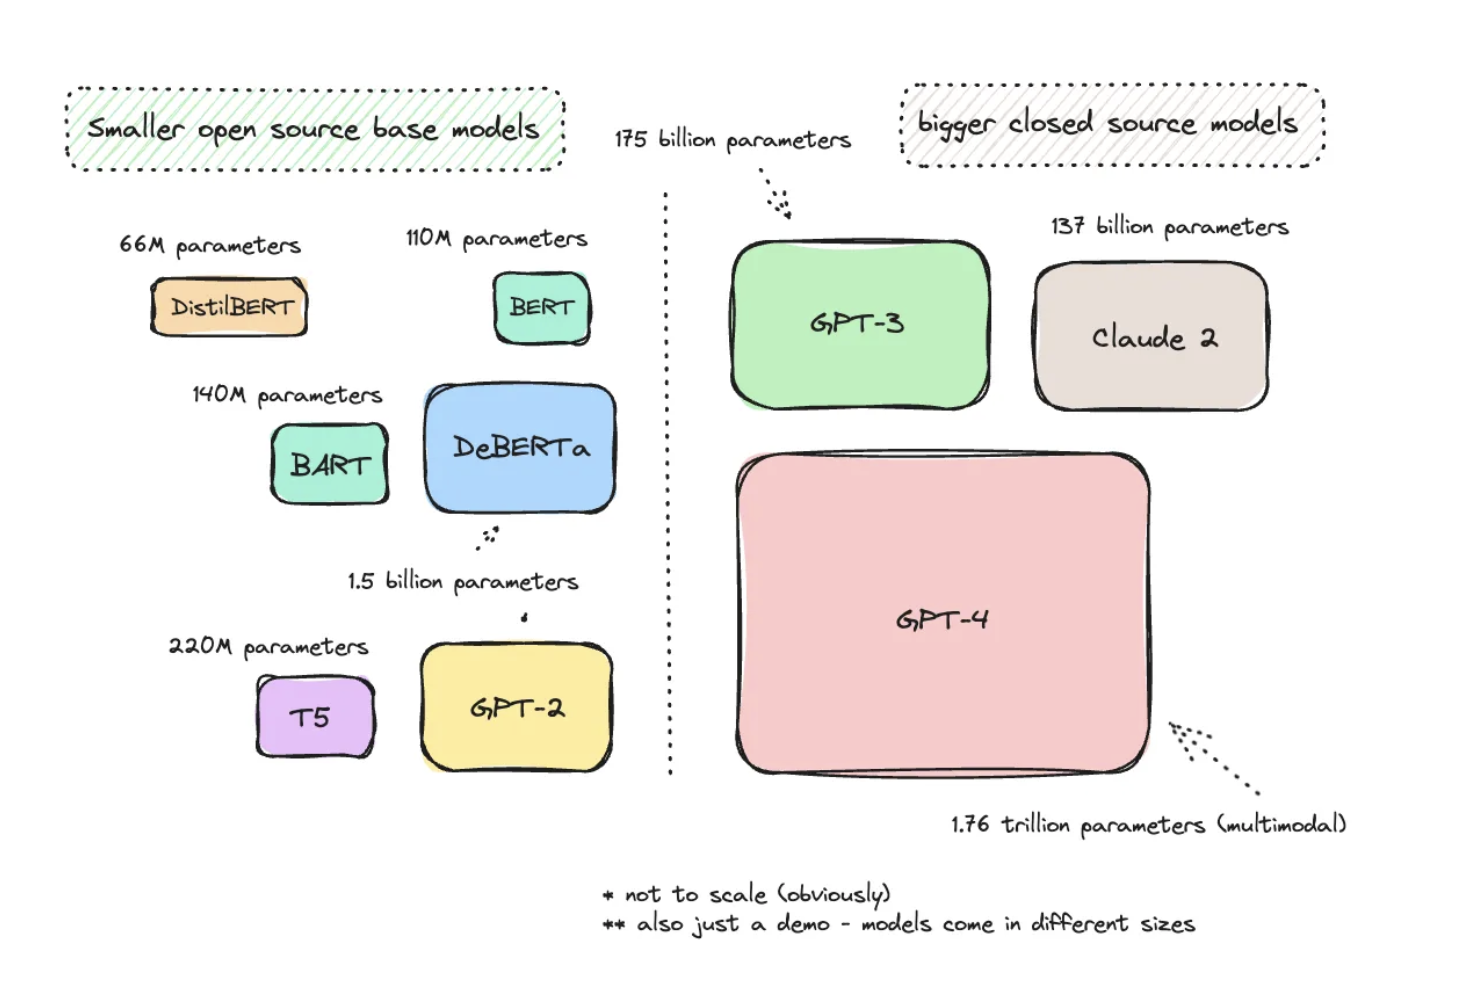

## Use Case: Keyword Extraction

In [2]:
from datasets import load_dataset

# import dataset from hugging face (it has two fields I'm interested in, 'text' and 'keywords')
dataset = load_dataset("ilsilfverskiold/tech-keywords-topics-summary")
# check the dataset
dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/7196 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/635 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/635 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url', 'text_length', 'keywords', 'topic', 'summary', '__index_level_0__'],
        num_rows: 7196
    })
    validation: Dataset({
        features: ['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url', 'text_length', 'keywords', 'topic', 'summary', '__index_level_0__'],
        num_rows: 635
    })
    test: Dataset({
        features: ['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url', 'text_length', 'keywords', 'topic', 'summary', '__index_level_0__'],
        num_rows: 635
    })
})

In [3]:
# map out some examples from the dataset
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Text: {example['text']}'")
        print(f"'>> Keywords: {example['keywords']}'")


show_samples(dataset)


'>> Text: Driverless car users will not be prosecuted for fatal crashes in UK'
'>> Keywords: Driverless Cars, Legal Issues, UK'

'>> Text: Google is embedding inaudible watermarks right into its AI generated music -'
'>> Keywords: Google, AI Music, Watermarks, Audio Technology'

'>> Text: What are your thoughts on Nextjs performance? Do you agree with this chart? - ( by 10up where Nextjs appears lower than WordPress on core vitals. Couldn’t post the image here due to community rules. But appreciate any other studies and thought you have on this matter.'
'>> Keywords: Next.js, Performance, 10up, WordPress'


In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# set the correct model you'll be fine-tuning
model_name = 'facebook/bart-large'
# get the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# check the token length of the keywords field - you can do this for both fields
texts = dataset['train']['keywords']

# Tokenize all texts and find the maximum length (max for BART is 1024 tokens)
max_token_length = max(len(tokenizer.encode(text, truncation=True)) for text in texts)
print(f"The longest text is {max_token_length} tokens long.")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


The longest text is 96 tokens long.


In [5]:
# convert both the input text and the target text into a format suitable for training a sequence-to-sequence model
# remember data preprocessing functions would look different if you were using a model with a different architecture, such as an encoder-only or decoder-only model.

def get_feature(batch):
  encodings = tokenizer(batch['text'], text_target=batch['keywords'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

dataset_pt = dataset.map(get_feature, batched=True)
dataset_pt

Map:   0%|          | 0/7196 [00:00<?, ? examples/s]

Map:   0%|          | 0/635 [00:00<?, ? examples/s]

Map:   0%|          | 0/635 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url', 'text_length', 'keywords', 'topic', 'summary', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7196
    })
    validation: Dataset({
        features: ['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url', 'text_length', 'keywords', 'topic', 'summary', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 635
    })
    test: Dataset({
        features: ['id', 'source', 'text', 'timestamp', 'reactions', 'engagement', 'url', 'text_length', 'keywords', 'topic', 'summary', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 635
    })
})

In [6]:

# the dataset should be formatted as PyTorch tensors with only the new fields
# i.e. specifies which columns should be returned when accessing the data - only the new fields will be returned
columns = ['input_ids', 'labels', 'attention_mask']
dataset_pt.set_format(type='torch', columns=columns)

In [7]:

# the data collator is responsible for dynamically padding the batches to the maximum length in each batch.
# which is crucial for efficient training of transformer models like BART or T5.
# padding will look different depending on the type of model you use, you can see here that this one is specifically for seq-to-seq

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [8]:

from transformers import TrainingArguments, Trainer

# start training the model
# we're using the Trainer API which abstracts away a lot of complexity
training_args = TrainingArguments(
    output_dir = 'bart_tech_keywords',
    num_train_epochs=3, # your choice
    warmup_steps = 500,
    per_device_train_batch_size=4, # keep a small batch size when working with a small GPU
    per_device_eval_batch_size=4,
    weight_decay = 0.01, # helps prevent overfitting
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=50, # base this on the size of your dataset and number of training epochs
    save_steps=1e6,
    gradient_accumulation_steps=16 # running this on a small GPU
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = dataset_pt['train'], eval_dataset = dataset_pt['validation'])

trainer.train()

Step,Training Loss,Validation Loss
50,1.457500,1.210455
100,1.200200,1.072994
150,1.025200,1.103859
200,0.953600,0.961380
250,0.901700,0.885267
300,0.882700,0.891639


TrainOutput(global_step=336, training_loss=1.2098183376448495, metrics={'train_runtime': 1134.1601, 'train_samples_per_second': 19.034, 'train_steps_per_second': 0.296, 'total_flos': 3591535684878336.0, 'train_loss': 1.2098183376448495, 'epoch': 2.99})

In [9]:
# save the model
trainer.save_model('tech-keywords-extractor') # set the name you want it to be called

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [12]:
from transformers import pipeline

# test the model using Hugging Face's pipeline
pipe = pipeline('summarization', model='tech-keywords-extractor')

# test the first item in the test set to see how it does
test_text=dataset['test'][0]['text']
keywords = dataset['test'][0]['keywords']
print("the text: ", test_text)
print("generated keywords: ", pipe(test_text))
print("orginal keywords : ",keywords)

Your max_length is set to 128, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


the text:  Unleash the Edge: Women’s Faux Leather Zip-Up Motorcycle Jacket — Vintage Grunge Aesthetic Revived - Ride the Rebel Wave: Women’s Faux Leather Zip-Up Motorcycle Jacket — A Fusion of Timeless Edge and Vintage Grunge Aesthetic for…
generated keywords:  [{'summary_text': "Women's Faux Leather Zip-Up Motorcycle Jacket, Vintage Grunge Aesthetic"}]
orginal keywords :  Women's Fashion, Faux Leather, Motorcycle Jacket, Vintage Grunge


In [13]:
# iterate over the test set to generate 50 examples at once
for i in range(0, 50):
    text_test = dataset['test'][i]['text']
    keywords = dataset['test'][i]['keywords']
    print("text: ", text_test)
    print("generated keywords: ", pipe(text_test)[0]['summary_text'])
    print("original keywords: ", keywords)

Your max_length is set to 128, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


text:  Unleash the Edge: Women’s Faux Leather Zip-Up Motorcycle Jacket — Vintage Grunge Aesthetic Revived - Ride the Rebel Wave: Women’s Faux Leather Zip-Up Motorcycle Jacket — A Fusion of Timeless Edge and Vintage Grunge Aesthetic for…


Your max_length is set to 128, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


generated keywords:  Women's Faux Leather Zip-Up Motorcycle Jacket, Vintage Grunge Aesthetic
original keywords:  Women's Fashion, Faux Leather, Motorcycle Jacket, Vintage Grunge
text:  Distractions, analytical thinking and falling for fake news


Your max_length is set to 128, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


generated keywords:  Distractions, analytical Thinking, Fake News, Journalism
original keywords:  Distractions, Analytical Thinking, Fake News
text:  If you buy a Cybertruck, Tesla says you can't sell it for a year


Your max_length is set to 128, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


generated keywords:  Cybertruck, Tesla, Vehicle Sale Restrictions
original keywords:  Cybertruck, Tesla, Resale Restriction
text:  ODROID-M1S is a $49 single-board PC with RK3566, 64GB eMMC and an M.2 2280 slot


Your max_length is set to 128, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


generated keywords:  ODROID-M1S, RK3566, eMMC, M.2 2280, Single-board PC
original keywords:  ODROID-M1S, RK3566, Single-Board PC, M.2 Slot
text:  ChatGPT-Admin-Web - One-stop system for shared use of AI within teams and organizationswith |  - English ChatGPT Admin Web CAW GitHub Sponsor / Features V3 V2 + topics: ai-system, chatgpt, gpt-4, llm, llvm, newbing, nextjs, postgresql, prisma, prompt, user-management, webui


Your max_length is set to 128, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


generated keywords:  ChatGPT-Admin-Web, AI, CAW, GitHub, Next.js, PostgreSQL, Prisma, Prompt, User-Management, Webui
original keywords:  ChatGPT-Admin-Web, AI, ChatGPT, GPT-4, LLM, LLVM, Newbing, Next.js, PostgreSQL, Prisma, User Management, WebUI
text:  Microsoft Azure CTO Headhunted for SDE II Position at Amazontwitter.com/markrussinovich
generated keywords:  Microsoft Azure, CTO, SDE II, Headhunted, Mark Russinovich
original keywords:  Microsoft Azure, Microsoft, Azure, CTO, Amazon, Mark Russinovich
text:  Self-Hosting-Guide - Self-Hosting Guide. Learn all about locally hosting  and managing software applications by yourself or your organization. Including Cloud, LLMs, WireGuard, Automation, Home Assistant, and Networking. - Self Hosting Guide A guide for getting started with Self Hosting devices including software and hardware that will make you a better and more efficient Self Hosting. Note: You can easily convert this markdown file to a PDF in VSCode using this handy extension Ma

Your max_length is set to 128, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


generated keywords:  Self-Hosting, Cloud, LLMs, WireGuard, Automation, Home Assistant, Networking, Authentication, Open Source, Privacy, Raspberry Pi, Reverse Proxy, Search
original keywords:  Self Hosting, Cloud, LLMs, WireGuard, Automation, Home Assistant, Networking, Authentication, Docker, Docker Compose, Linux, OAuth, Observability, Open Source, Privacy, Raspberry Pi, Reverse Proxy, Search, SSH
text:  Pendulation is normal - Think of a pendulum. When you push it in one direction, it swings back with opposite force.


Your max_length is set to 128, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


generated keywords:  Pendulum, Normal Mechanism, Physiology
original keywords:  Pendulation, Pendulum
text:  ChatGPT Voice for Medium Article Writers and Content Creators - Unleash the Conversation with AI


Your max_length is set to 128, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


generated keywords:  ChatGPT, Voice, Medium, Article Writers, Content Creators, AI
original keywords:  ChatGPT, Voice, Medium, Content Creation
text:  CookieCloud - CookieCloudCookieCookieLocal storage - CookieCloudCookieCloudCookieCookieLocal storagelocal storageTelegram | Telegram Breaking Change local storage 0.1.5+ cookie local storagecookie{ cookie_data, local_storage_data } remote local


Your max_length is set to 128, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


generated keywords:  CookieCloud, CookieCloudCookieCookie, Local Storage, Telegram
original keywords:  CookieCloud, Local Storage, Telegram, Breaking Change
text:  Essential Resources to Learn App Development for Apple Vision Pro -


Your max_length is set to 128, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


generated keywords:  App Development, Apple Vision Pro, App Development Resources
original keywords:  App Development, Apple Vision Pro
text:  developer-roadmap - Interactive roadmaps, guides and other educational content to help developers grow in their careers. - roadmap.sh Community driven roadmaps, articles and resources for developers Roadmaps are now interactive, you can click the nodes to read more about the topics.View all Roadmaps Best Practices QuestionsHere is the list of available roadmaps with more being actively worked upon.Frontend Roadmap / Frontend Beginner RoadmapBackend RoadmapDevOps Roadmap / DevOps Beginner RoadmapFull Stack RoadmapComputer Scie


Your max_length is set to 128, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


generated keywords:  developer-roadmap, Roadmaps, Guides, Educational Content, DevOps
original keywords:  developer-roadmap, Developer Roadmap, Interactive Roadmaps, Frontend Roadmap, Backend Roadmap, DevOps Roadmap, Full Stack Roadmap, Computer Science, Road Map
text:  Leaflet - JavaScript library for mobile-friendly interactive maps - Leaflet was created 11 years ago by Volodymyr Agafonkin, a Ukrainian citizen living in Kyiv.Russian bombs are now falling over Volodymyr's hometown. His family, his friends, his neighbours, thousands and thousands of absolutely wonderful people, are either seeking refuge or fighting for their lives.Russian soldiers have already killed tens of thousands of civilians, including women and children, and are committing mass war crimes like gang rapes, executions, looting, and targeted bombings of c


Your max_length is set to 128, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


generated keywords:  Leaflet, JavaScript, Interactive Maps, Ukraine, Russian War Crimes
original keywords:  Leaflet, JavaScript, Interactive Maps, Volodymyr Agafonkin, Ukraine, Kyiv
text:  We Are In A Simulation | The Game Of Life Explained - “You are either the main character, a supporting actor, or an extra. Which one are you?”


Your max_length is set to 128, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


generated keywords:  Simulation, Game Theory, Supporting Actor, Extra
original keywords:  Simulation Theory, Game of Life
text:  OpenAI Dev Day lo más relevante - El 6 de Noviembre se llevó a cabo el primer OpenAI Dev Day en San Francisco, y como era de esperarse, se presentaron grandes sorpresas.


Your max_length is set to 128, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


generated keywords:  OpenAI Dev Day, OpenAI, San Francisco
original keywords:  OpenAI, DevDay, San Francisco
text:  Top 10 Programming Memes Every Developer Can Relate To - If you want to receive an exclusive programming meme every Monday to your inbox, sign up for my newsletter


Your max_length is set to 128, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


generated keywords:  Programming Memes, Developer, Email Newsletter
original keywords:  Programming Memes, Developer, Newsletter
text:  Is sessionStorage useful in React applications? - Why would you ever save data to sessionStorage when you could just store it in the React application in the form of e.g. globalState ? Any benefits to storing data in sessionStorage in React?
generated keywords:  sessionStorage, React, Data Storage, globalState
original keywords:  sessionStorage, React, Global State
text:  Worth suing co-founders? - Took an equity position as technical co-founder plus cash incentive and they don’t want to pay now. Contract is a bit of mess on top of it. I’m owed multiple 6 figures for promised sweat equity, but the company isn’t generating what anyone thought it would. There was never a contingency based on success of the company or revenue generated. My choices are basically sue, or try to dissolve company and negotiate to keep all rights to all digital assets, tradema

Your max_length is set to 128, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


generated keywords:  Technical Co-founder, Lawsuit, Digital Assets, Trademarks, Domain
original keywords:  Equity, Technical Co-founder, founder, Contract, Sue, Intellectual Property, IP, Trademarks, Domain
text:  No. Americans Runners Have NOT Never Been Slower - A Critique of Run Repeat’s 2017 Mega Study on Marathons


Your max_length is set to 128, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


generated keywords:  Americans Runners, Run Repeat, Marathons
original keywords:  American Runners, Run Repeat, Marathons, Study Critique
text:  spectest - API testing library for Go that generate E2E test result document in markdown - Generate document from end-to-end tests In recent years, Domain-Driven Design  has become mainstream, making it easier to implement unit tests for methods in each layer. However, implementing end-to-end  tests can be quite labor-intensive. To achieve a return on the effort invested, I am d... + tags: showdev, go, testing, api


Your max_length is set to 128, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


generated keywords:  spectest, API Testing, Go, Domain-Driven Design, E2E, Markdown
original keywords:  spectest, API Testing, Go, E2E Tests, Markdown, Domain-Driven Design
text:  Data Cleansing & Manipulation - Data cleaning or Data cleansing and manipulation is a crucial step in a data project that involves identifying and correcting errors or…


Your max_length is set to 128, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


generated keywords:  Data Cleansing, Manipulation, Data Project
original keywords:  Data Cleansing, Data Manipulation, Data Science
text:  State Management with Nested Signals  - Experimental Angular state management with nested signals


Your max_length is set to 128, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


generated keywords:  State Management, Nested Signals, Angular
original keywords:  State Management, Angular, Nested Signals
text:  Submit Black Friday Deal - Hey SaaS Founders, We're curating the ultimate list of top SaaS deals in our SaaS community, and we want your startup to be featured. Got an incredible Black Friday offer of your SaaS startup? Share it with us through the form below, we will include your SaaS offer to our list: 


Your max_length is set to 128, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


generated keywords:  Black Friday, SaaS, Startup, Startup Deal
original keywords:  Black Friday, SaaS, Startup, Community, Deals
text:  Harnessing the Power of Behavioural Data in the Insurance Industry - Companies are progressively employing behavioral data analytics within the insurance sector to acquire more profound insights into customer…


Your max_length is set to 128, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


generated keywords:  Behavioural Data, Insurance Industry, Data Analytics
original keywords:  Behavioural Data, Insurance Industry
text:  Understanding Feature Importance in Machine Learning: Beyond the Numbers - In the realm of machine learning, the concept of feature importance plays a crucial role in understanding how models make predictions…


Your max_length is set to 128, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


generated keywords:  Feature Importance, Machine Learning, Predictions
original keywords:  Feature Importance, Machine Learning
text:  Python Kullanarak Kitap Öneri Sistemi Oluşturmanın Temel Adımları (TFIDF ve Cosine Similarty… - Özet:  Kitap okuma deneyimini kişiselleştirmek için Python kullanarak nasıl bir kitap öneri sistemi oluşturabileceğinizi adım adım…


Your max_length is set to 128, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


generated keywords:  Python, Temel Adımlar, TFIDF, Cosine Similarty
original keywords:  Python, Recommendation System, Book Recommendation, TFIDF, Cosine Similarity
text:  Advise for moving forward - It should be noted that I’m not a programmer. The extent of my programming has been manipulating calculation functions in already existing code. In other words, no experience. I work for a company that develops scanners and optimizers for lumber industry. With this comes the user interface to observe solutions based on data that the scanner sees and the parameter set in the optimizer. My company


Your max_length is set to 128, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


generated keywords:  Programming, Lumber Industry, Scanners, Optimizers
original keywords:  Programming, Lumber Industry, User Interface, Scanners, Optimizers
text:  JavaScript Project with Zero JavaScript Knowledge?  - Can’t be that hard? Same as Java without the Script…


Your max_length is set to 128, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


generated keywords:  JavaScript, Project Management, JavaScript Knowledge, Java
original keywords:  JavaScript, Java
text:  Top 20 Front-End Interview Questions You Must Know - In this article, you’ll uncover a handpicked collection of some of the most prominent questions you might encounter in a frontend web…


Your max_length is set to 128, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


generated keywords:  Front-End Interview Questions, Interview, Web Development
original keywords:  Front-End, Interview Questions
text:  Show HN: A custom GPT conversational language tutor that generates Anki cards


Your max_length is set to 128, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


generated keywords:  GPT, Conversational Language Tutor, Anki Cards
original keywords:  GPT, Anki, Conversational Language Tutor
text:  DEM: Open-source containerized Development Environment Manager


Your max_length is set to 128, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


generated keywords:  DEM, Open Source, Containerized Development Environment Manager
original keywords:  DEM, Open-source, Containerization, Development Environment Manager
text:  Exploring the Power and Simplicity of the Go Programming Language - Diving into Go’s Features, from Concurrency to Web Development, with Code Examples and Best Practices


Your max_length is set to 128, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


generated keywords:  Go, Programming Language, Concurrency, Web Development
original keywords:  Go Programming Language, Concurrency, Web Development
text:  Bytes: A fast, lightweight and customizable text editor


Your max_length is set to 128, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


generated keywords:  Bytes, Text Editor, Lightweight, Customizable
original keywords:  Bytes, Text Editor
text:  Why we're building Scanner: data lake search must be fastscanner.dev


Your max_length is set to 128, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


generated keywords:  Scanner, Data Lake Search, Fastscanner.dev
original keywords:  Scanner, Data Lake, Search Performance, Performance
text:  In-depth Understanding to Optimize the Performance of Artificial Neural Network - Hyper-parameters tuning for deep learning techniques


Your max_length is set to 128, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


generated keywords:  Artificial Neural Network, Hyperparameters Tuning, Deep Learning
original keywords:  Artificial Neural Network, Hyper-parameters, Deep Learning, Performance Optimization
text:  Deep Dive into Continuous Distributions and Bayesian Inference - In the realms of statistics and probability theory, continuous distributions are pivotal for modeling and understanding various types of…


Your max_length is set to 128, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


generated keywords:  Continuous Distributions, Bayesian Inference, Statistics, Probability Theory
original keywords:  Continuous Distributions, Bayesian Inference, Statistics, Probability Theory
text:  How To Setup A Cloudflare Tunnel And Expose Your Local Service Or Application. -


Your max_length is set to 128, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


generated keywords:  Cloudflare, Tunnel, Local Service, Application Security
original keywords:  Cloudflare Tunnel, Cloudflare, Local Service, Application Exposure
text:  Joby Performs First EVTOL Test Flights in New York


Your max_length is set to 128, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


generated keywords:  Joby, EVTOL, Test Flights, New York
original keywords:  Joby, EVTOL, Test Flights, New York
text:  Find Your AI Solutions at the ODSC West AI Expo - At the AI Expo and Demo Hall as part of ODSC West in a few weeks, you’ll have the opportunity to meet one-on-one with representatives from…


Your max_length is set to 128, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


generated keywords:  AI Expo, ODSC West, Demo Hall
original keywords:  AI Solutions, ODSC West, AI Expo
text:  Python Fundamentals you should have a good understanding on as a beginner coder - From Vanilla JavaScript, React.js to Python and SQL in Just 6 Weeks


Your max_length is set to 128, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


generated keywords:  Python, JavaScript, React.js, SQL, Beginner Coder
original keywords:  Python, JavaScript, React.js, SQL, Coding Fundamentals
text:  How to write a program that shuts off pc after a few seconds of inactivity - I have never written a program, but I would like to make something which allows me to monitor either a program's activity or keyboard activity and shuts off my pc or a program after a set amount of time . The motivation is that I want to sometimes pressure myself into writing quickly, and something like this would force me to write my thoughts out on t


Your max_length is set to 128, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


generated keywords:  Program, Program Monitoring, Keyboard Activity, Inactivity
original keywords:  Program, PC Shutdown, Inactivity, Writing Productivity
text:  The Foundation Models Reshaping Computer Vision - Learn about the Foundation Models — for object classification, object detection, and segmentation —  that are redefining Computer Vision.


Your max_length is set to 128, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


generated keywords:  Foundation Models, Computer Vision, Object Classification, Object Detection, Segmentation
original keywords:  Foundation Models, Computer Vision, Object Classification, Object Detection, Segmentation
text:  Unable to SSH into AWS hosted Ubuntu server. What am I missing? - I created a VPC, a subnet within it, attached an internet gateway, created a network interface, attached an elastic IP to the network interface and stood up the sever within the subnet in said VPC. The server is the only infrastructure inside of the VPC. I am still not able to connect to the server using SSH. Would I need to attach the elastic IP to the server to make this happen? Or add a load balancer to the VPC that targets traffic to the server?


Your max_length is set to 128, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


generated keywords:  AWS, AWS Hosted, Ubuntu, SSH, Elastic IP, Load Balancer
original keywords:  SSH, AWS, Ubuntu, VPC, Elastic IP, Network Interface
text:  Stop using Lambda Layers  - Lambda layers are a special packaging mechanism provided by AWS Lambda to manage dependencies for zip-based Lambda functions. Layers themselves are nothing more than a sparkling zip file, but they have a few interesting properties which prove useful in some cases. Unfortunately Lambda layers are als... + tags: aws, lambda, webdev, programming


Your max_length is set to 128, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


generated keywords:  Lambda Layers, AWS Lambda, Lambda Functions, Dependencies, Web Development, Programming
original keywords:  AWS, Lambda, Lambda Layers, Layers, Dependencies, Packaging
text:  Satiresoft: Why aren’t we doing AI? - This week at Satiresoft…


Your max_length is set to 128, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


generated keywords:  Satiresoft, AI, Satiresoft Conference
original keywords:  Satiresoft, AI
text:  At the Intersection of LLMs and Kernels - Research Roundup -


Your max_length is set to 128, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


generated keywords:  LLMs, Kernels, Research Roundup, Research
original keywords:  LLMs, Kernels, Research
text:  Alan Wake 2 is an unexpected visual marvel even on older GPUsxfire.com
generated keywords:  Alan Wake 2, GPUs, Visual Wonders, Xfire
original keywords:  Alan Wake 2, GPUs, Visual Marvel
text:  I am worried with how AI is improving propaganda - If you’ve been following the war in the Middle East on Twitter, you’ve probably noticed how difficult it’s been to distinguish what is real and what isn’t. Without getting into the gruesome details, a few days ago there was an image going around of a deceased child and there was heavy discussion into whether it was ai generated or real. There are some ai identifying tools but they appear to be very unreliable at the moment, so we don’t have a concrete way to make this distinction. I don’t know what the final findings were for that particular image, but either way it exemplifies how AI can be used to make dangerous propaganda. Apparent

Your max_length is set to 128, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


generated keywords:  AI, Propaganda, Google, Digital Watermark
original keywords:  AI, Propaganda, Digital Watermark, Google, Legislation
text:  Frank & FuelStat Launch - This month the Fuelet Wallet team has introduced two analytic tools for the Fuel Network users. Those are:


Your max_length is set to 128, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


generated keywords:  Frank, FuelStat, Fuelet Wallet, Fuel Network
original keywords:  Frank, FuelStat, Fuelet Wallet, Fuel Network, Analytics Tools
text:  Big Tech on Defensive as Copyright Threat Looms Over Generative AI. - Photo by Xu Haiwei on Unsplash
generated keywords:  Big Tech, Copyright Threat, Generative AI
original keywords:  Big Tech, Copyright, Generative AI, Xu Haiwei


In [14]:
# if you're satisfied we can push it to Hugging Face
# you'll need a token from your Hugging Face account to log in
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [15]:

# you would replace your own name here
# you do not need to create a repository beforehand
trainer.push_to_hub("Andyrasika/tech-keywords-extractor")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

events.out.tfevents.1706172525.713ebec0cd2e.1192.0:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Andyrasika/bart_tech_keywords/commit/fc2bae8b2b5d8126d51f7c80581abe7f94499fef', commit_message='Andyrasika/tech-keywords-extractor', commit_description='', oid='fc2bae8b2b5d8126d51f7c80581abe7f94499fef', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
## https://github.com/ilsilfverskiold/transformers-nlp-docs/blob/main/cook/fine-tune/fine_tune_seqtoseq_tech_keywords_dataset.ipynb